In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('Plant_Village', output="dataset", seed=1337, ratio=(.8, .1,.1))

Copying files: 61486 files [00:11, 5287.96 files/s]


## **Data Preprocessing**

In [ ]:
train_dir = "/content/dataset/train"
validation_dir = "/content/dataset/val"

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 49179 files belonging to 39 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)
test_dir = "/content/dataset/test"
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 6139 files belonging to 39 classes.
Found 6168 files belonging to 39 classes.


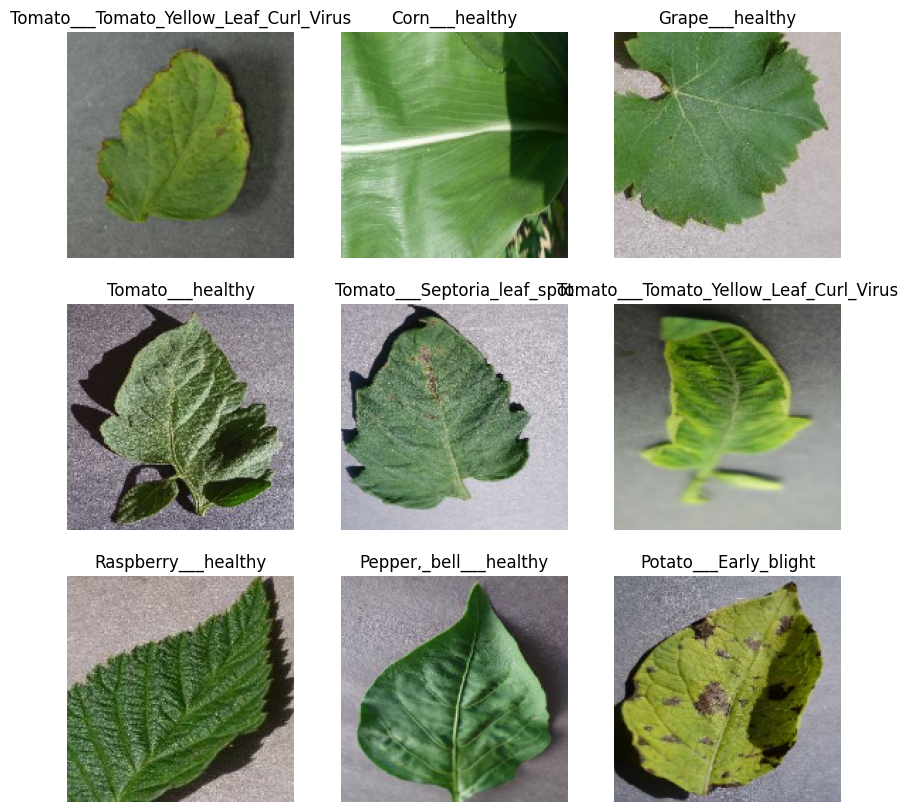

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

## **Create the base model from the pre-trained convnets**

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1792)


## **Feature extraction**
**Freeze the convolutional base**

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "efficientnetb4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 160, 160, 3)    │              0 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 160, 160, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 160, 160, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 161, 161, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 80, 80, 48)     │          1,296 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 80, 80, 48)     │            192 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 80, 80, 48)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 80, 80, 48)     │            432 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 80, 80, 48)     │            192 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 80, 80, 48)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 48)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 48)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 12)       │            588 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 17,673,823 (67.42 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1792)


In [ ]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 39)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 5, 5, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 39)                  │          69,927 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,743,750 (67.69 MB)

 Trainable params: 69,927 (273.15 KB)

 Non-trainable params: 17,673,823 (67.42 MB)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
initial_epochs = 6

loss0, accuracy0 = model.evaluate(validation_dataset)

192/192 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.0184 - loss: 3.7205


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.72
initial accuracy: 0.02


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 156s 77ms/step - accuracy: 0.6928 - loss: 1.2347 - val_accuracy: 0.9060 - val_loss: 0.3458
Epoch 2/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 103s 65ms/step - accuracy: 0.8957 - loss: 0.3725 - val_accuracy: 0.9280 - val_loss: 0.2492
Epoch 3/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step - accuracy: 0.9184 - loss: 0.2810 - val_accuracy: 0.9355 - val_loss: 0.2124
Epoch 4/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 100s 65ms/step - accuracy: 0.9255 - loss: 0.2491 - val_accuracy: 0.9410 - val_loss: 0.1906
Epoch 5/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 98s 64ms/step - accuracy: 0.9293 - loss: 0.2245 - val_accuracy: 0.9456 - val_loss: 0.1731
Epoch 6/6
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 143s 64ms/step - accuracy: 0.9349 - loss: 0.2062 - val_accuracy: 0.9464 - val_loss: 0.1626


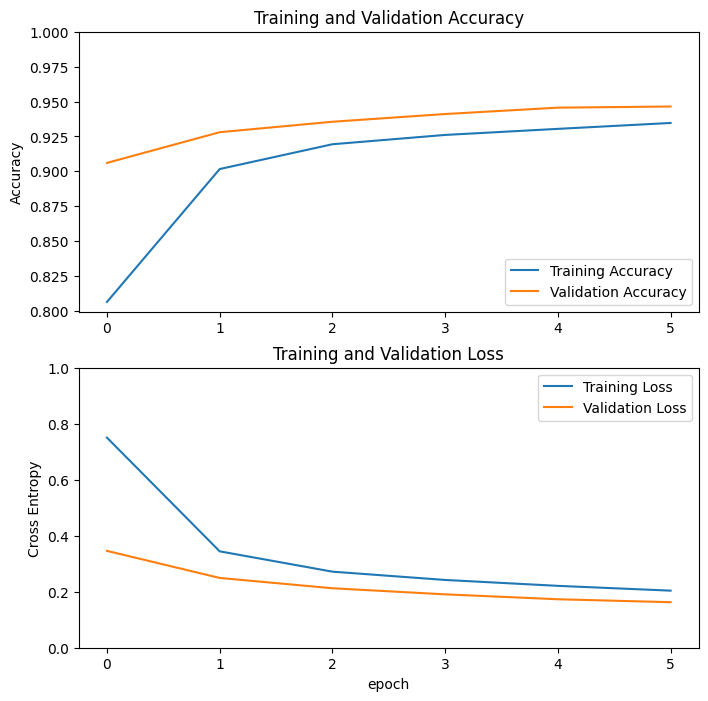

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## **Fine tuning**

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  475


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 5, 5, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 39)                  │          69,927 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,743,750 (67.69 MB)

 Trainable params: 17,531,783 (66.88 MB)

 Non-trainable params: 211,967 (828.00 KB)

In [ ]:
len(model.trainable_variables)

333

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)

Epoch 7/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 469s 229ms/step - accuracy: 0.8891 - loss: 0.3985 - val_accuracy: 0.9469 - val_loss: 0.1673
Epoch 8/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 282s 164ms/step - accuracy: 0.9608 - loss: 0.1067 - val_accuracy: 0.9749 - val_loss: 0.0561
Epoch 9/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 261s 163ms/step - accuracy: 0.9695 - loss: 0.0758 - val_accuracy: 0.9247 - val_loss: 0.1206
Epoch 10/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 261s 162ms/step - accuracy: 0.9645 - loss: 0.0675 - val_accuracy: 0.9464 - val_loss: 0.1105
Epoch 11/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 263s 163ms/step - accuracy: 0.9710 - loss: 0.0591 - val_accuracy: 0.9708 - val_loss: 0.0548
Epoch 12/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 261s 162ms/step - accuracy: 0.9744 - loss: 0.0476 - val_accuracy: 0.9474 - val_loss: 0.5304
Epoch 13/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 263s 163ms/step - accuracy: 0.9700 - loss: 0.0372 - val_accuracy: 0.9528 - val_loss: 0.0788
Epoch 14/16
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 263s 164ms/step

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

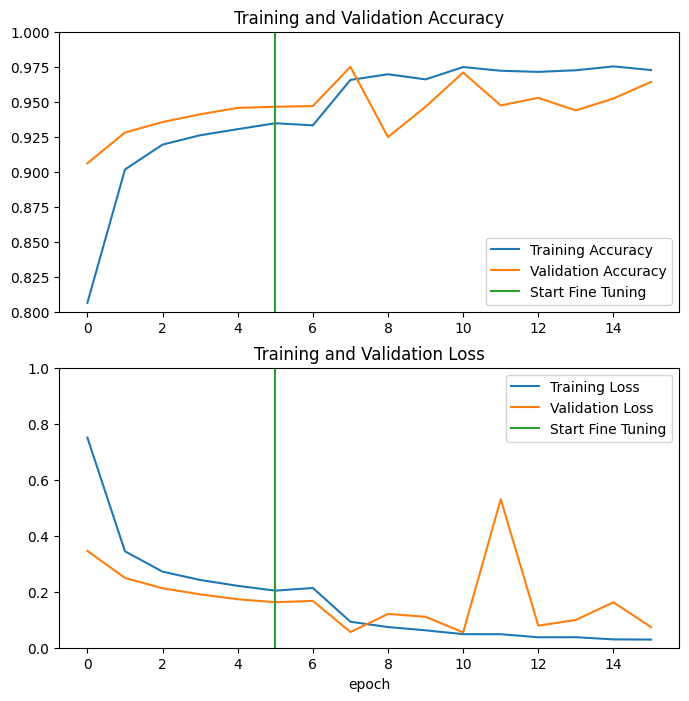

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

193/193 ━━━━━━━━━━━━━━━━━━━━ 20s 103ms/step - accuracy: 0.9651 - loss: 0.0604
Test accuracy : 0.9644941687583923


Predictions:
 [35 26 17 19  1 33 11 29 29 13 26  9 26 25 35  0  0 16 24  9 29 35  9 12
 14  6  2 33 21 16  1 14]
Labels:
 [35 26 17 19  1 33 11 29 29 13 26  9 28 25 35  0  0 16 24  9 29 35  9 12
 14  6  2 33 21 16  1 14]


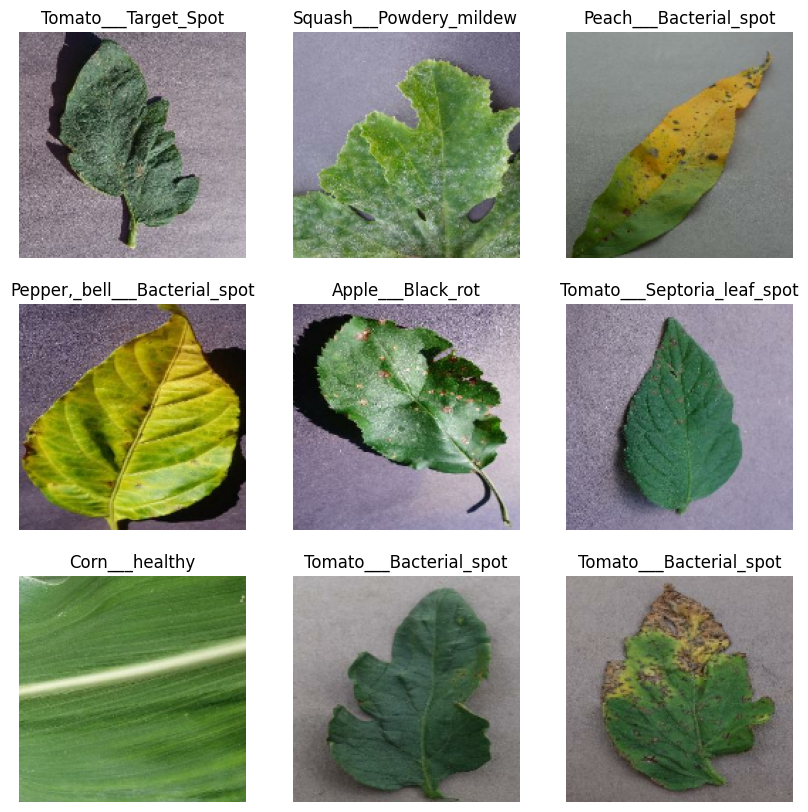

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
predictions = tf.argmax(predictions,axis=1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## **Saving Model**

In [ ]:
model.save("plant_disease_detect_model_pwp.keras")